<a style="color: green; text-align: center; font-size: 30px; font-weight: bold;">🔮 Predictive Modeling for Insurance Claims 🏦<a/>

The machine learning lab on Predictive Modeling for Insurance Claims.

> **Name**: Byamugisha Africano - 1800704595
>
> **Registration No**: 2023/HD05/04595/U
>
> **Student No**: 1800704595
>
> **Date**: November 10, 2023
    
## Objective
- To develop a robust predictive model to determine if a building will have an insurance claim during a specific period based on various building characteristics.
- The primary objective of this assignment is to explore and apply four machine learning algorithms—Support Vector Machine (SVM), Linear Regression, k-nearest Neighbors (KNN), and Naive Bayes. And the models will be evaluated using the Area Under the Curve (AUC) metric.

## Dataset Description
The dataset includes the following variables:

| Variable            | Description                                                                        |
|---------------------|------------------------------------------------------------------------------------|
| Customer Id         | Identification number for the Policy holder                                        |
| YearOfObservation   | Year of observation for the insured policy                                         |
| Insured_Period      | Duration of insurance policy in Olusola Insurance. (Ex: Full year insurance, Policy Duration = 1; 6 months = 0.5) |
| Residential         | Is the building a residential building or not                                       |
| Building_Painted    | Is the building painted or not (N-Painted, V-Not Painted)                           |
| Building_Fenced     | Is the building fence or not (N-Fenced, V-Not Fenced)                               |
| Garden              | Building has a garden or not (V-has garden; O-no garden)                             |
| Settlement          | Area where the building is located. (R- rural area; U- urban area)                   |
| Building Dimension  | Size of the insured building in m2                                                  |
| Building_Type       | The type of building (Type 1, 2, 3, 4)                                             |
| Date_of_Occupancy   | Date the building was first occupied                                               |
| NumberOfWindows     | Number of windows in the building                                                   |
| Geo Code            | Geographical Code of the Insured building                                           |
| Claim               | Target variable. (0: no claim, 1: at least one claim over insured period)           |



In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math as math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

np.random.seed(123)

In [2]:
dt_train = pd.read_csv("dataset/train_data.csv")
dt_train['Dataset'] = 'Train'

dt_test = pd.read_csv("dataset/test_data.csv")
dt_test['Dataset'] = 'Test'

dt = dt_train.append(dt_test, ignore_index=True)
dt_original = dt

# Data Exploration

## Initial Data Exploration & Transfromation

In [3]:
dt[dt['Dataset'] == 'Train'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7160 entries, 0 to 7159
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   float64
 14  Dataset             7160 non-null   object 
dtypes: float64(4), int64(3), object(8)
memory usage: 895.0+

In [4]:
print("Number of rows:", dt_train.shape[0])
print("Number of columns:", dt_train.shape[1])
print("Number of numeric columns:", dt_train.select_dtypes(include=['number']).shape[1])
print("Number of categorical columns:", dt_train.select_dtypes(exclude=['number']).shape[1])

Number of rows: 7160
Number of columns: 15
Number of numeric columns: 7
Number of categorical columns: 8


In [5]:
dt[dt['Dataset'] == 'Train'].head(5)

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim,Dataset
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0.0,Train
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0.0,Train
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0.0,Train
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0.0,Train
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0.0,Train


In [6]:
# Recode the Variable to actual value
dt["Residential"] = dt["Residential"].replace(
    {
        1:'Yes',
        0:'No'
    }
)

dt["Building_Painted"] = dt["Building_Painted"].replace(
    {
        'N':'Painted',
        'V':'Not Painted'
    }
)

dt["Building_Fenced"] = dt["Building_Fenced"].replace(
    {
        'N':'Fenced',
        'V':'Not Fenced'
    }
)

dt["Garden"] = dt["Garden"].replace(
    {
        'V':'Has Garden',
        'O':'No Garden',
    }
)


dt["Settlement"] = dt["Settlement"].replace(
    {
        'R':'Urban Area',
        'U':'Rural Area'
    }
)

# dt["Building_Type"].unique()
# dt["Building_Type"].dtype

dt["Building_Type"] = dt["Building_Type"].replace(
    {
        1:'Type 1',
        2:'Type 2',
        3:'Type 3',
        4:'Type 4'
    }
).astype(pd.CategoricalDtype(categories=['Type 1', 'Type 2', 'Type 3', 'Type 4'], ordered=True))

dt["Claim"] = dt["Claim"].replace(
    {
        0:'No Claim',
        1:'Atleast 1 Claim'
    }
)

# dt["NumberOfWindows"].unique()
dt["NumberOfWindows"] = dt["NumberOfWindows"].replace({
    '1': '1 to 5',
    '2': '1 to 5',
    '3': '1 to 5',
    '4': '1 to 5',
    '5': '1 to 5',
    '6': '6 to 9',
    '7': '6 to 9',
    '8': '6 to 9',
    '9': '6 to 9',
    '>=10': '10 And Above',
    '   .': np.nan
}).astype(pd.CategoricalDtype(categories=['1 to 5', '6 to 9', '10 And Above'], ordered=True))


In [7]:
dt[dt['Dataset'] == 'Train'].head(5)

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim,Dataset
0,H14663,2013,1.0,No,Painted,Not Fenced,Has Garden,Rural Area,290.0,Type 1,1960.0,NaN,1053,No Claim,Train
1,H2037,2015,1.0,No,Not Painted,Fenced,No Garden,Urban Area,490.0,Type 1,1850.0,1 to 5,1053,No Claim,Train
2,H3802,2014,1.0,No,Painted,Not Fenced,Has Garden,Rural Area,595.0,Type 1,1960.0,NaN,1053,No Claim,Train
3,H3834,2013,1.0,No,Not Painted,Not Fenced,Has Garden,Rural Area,2840.0,Type 1,1960.0,NaN,1053,No Claim,Train
4,H5053,2014,1.0,No,Not Painted,Fenced,No Garden,Urban Area,680.0,Type 1,1800.0,1 to 5,1053,No Claim,Train


In [8]:
# print(dt["Geo_Code"].unique().tolist())

dt = dt.drop(columns = ['Geo_Code', 'Customer Id'])

In [9]:
# Checking for missing values
dt2 = dt[dt['Dataset'] == 'Train'].drop(columns = 'Claim')
pd.DataFrame({
    'Number of Missing Values': dt2.isnull().sum(),
    'Percentage Missing': round((dt2.isnull().sum() / dt2.shape[0]) * 100,2)
}).sort_values(by='Percentage Missing', ascending=False)


,Number of Missing Values,Percentage Missing
NumberOfWindows,3551,49.59
Date_of_Occupancy,508,7.09
Building Dimension,106,1.48
Garden,7,0.10
YearOfObservation,0,0.00
Insured_Period,0,0.00
Residential,0,0.00
Building_Painted,0,0.00
Building_Fenced,0,0.00
Settlement,0,0.00


In [10]:
dt = dt.drop(columns = ['NumberOfWindows'])

In [11]:
dt["YearsOfOccupancyBeforeClaim"] = dt["YearOfObservation"]-dt["Date_of_Occupancy"] 

In [12]:
dt = dt.drop(columns = ['YearOfObservation','Date_of_Occupancy'])

In [13]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10229 entries, 0 to 10228
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Insured_Period               10229 non-null  float64 
 1   Residential                  10229 non-null  object  
 2   Building_Painted             10229 non-null  object  
 3   Building_Fenced              10229 non-null  object  
 4   Garden                       10218 non-null  object  
 5   Settlement                   10229 non-null  object  
 6   Building Dimension           10110 non-null  float64 
 7   Building_Type                10229 non-null  category
 8   Claim                        7160 non-null   object  
 9   Dataset                      10229 non-null  object  
 10  YearsOfOccupancyBeforeClaim  8993 non-null   float64 
dtypes: category(1), float64(3), object(7)
memory usage: 809.5+ KB


In [14]:
# Training Data Frame for
dt_t = dt[dt["Dataset"] == "Train"]

In [15]:
dt_t = dt_t.drop(columns = "Dataset")

In [16]:
dt_t.dropna(inplace=True)

## Univariate Analysis

### Target Variable

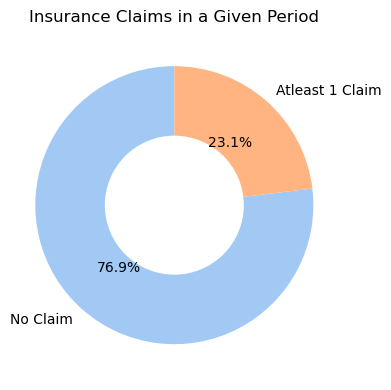

In [17]:
data = dt_t['Claim'].value_counts()
labels = data.index
sizes = data.values

palette_color = sns.color_palette('pastel')

plt.figure(figsize=(4, 4))

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=palette_color)

centre_circle = plt.Circle((0,0),0.5,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal') 

plt.title('Insurance Claims in a Given Period')
plt.tight_layout()

plt.show()

As illustrated in the pie chart Above, a significant majority of the customers(76.9%) have not made an issurance claim, whereas 23.1% have made atleast an issurance claim

### Other Variables

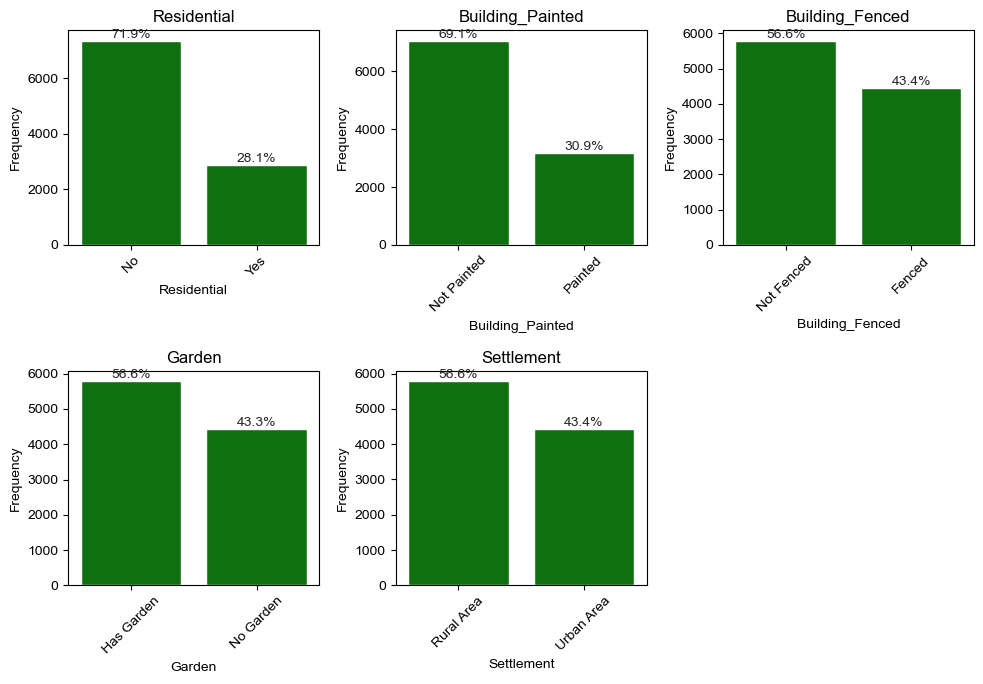

In [18]:
categorical_columns = dt.select_dtypes(include=['object']).drop(columns=['Claim', 'Dataset'])

def plot_countplot_with_percentages(data, title, ax):
    sns.set(style="whitegrid", palette="pastel")
    ax = sns.countplot(x=data, data=dt, order=dt[data].value_counts().index, color='green', ax=ax)
    total_data_points = len(dt)
    
    for p in ax.patches:
        height = p.get_height()
        percentage = f'{100 * height / total_data_points:.1f}%'
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=10)
    ax.set_ylabel('Frequency')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(title)


num_rows = len(categorical_columns.columns) // 3 + 1
fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3.5 * num_rows))
axes = axes.flatten()

for i in range(len(categorical_columns.columns), len(axes)):
    fig.delaxes(axes[i])

for i, column in enumerate(categorical_columns.columns):
    plot_countplot_with_percentages(column, f'{column}', axes[i])

plt.tight_layout()
plt.show()


## Bi Variate Analysis

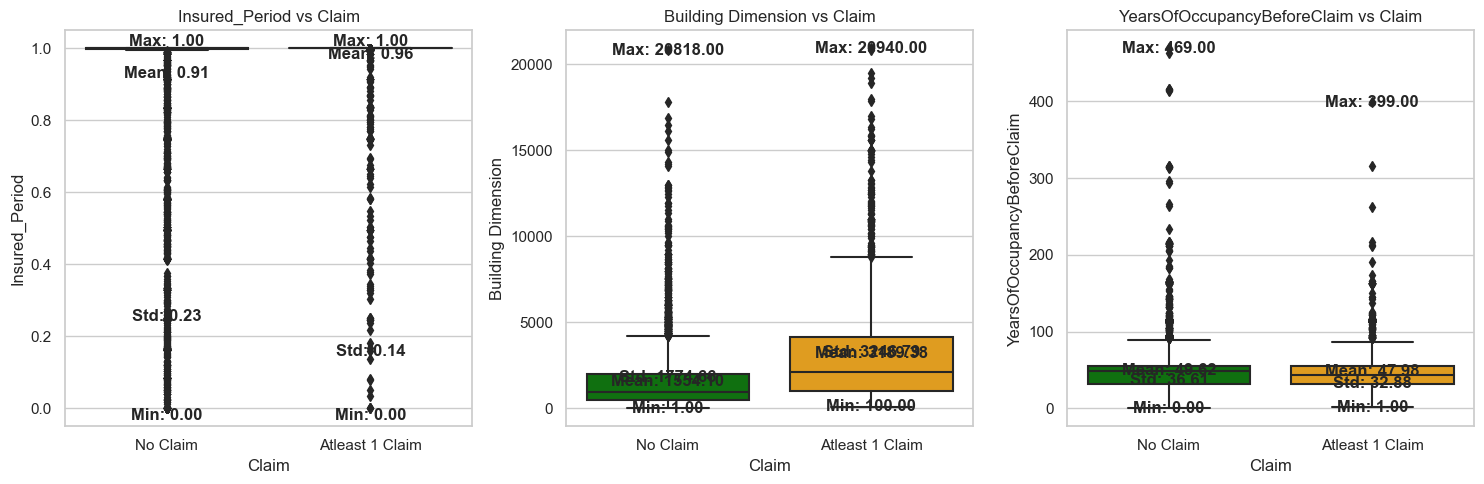

In [19]:
numerical_vars = ['Insured_Period', 'Building Dimension', 'YearsOfOccupancyBeforeClaim']

colors = {'No Claim': 'green', 'Atleast 1 Claim': 'orange'}

sns.set(style="whitegrid")

fig, axes = plt.subplots(ncols=len(numerical_vars), figsize=(15, 5))

for i, var in enumerate(numerical_vars):
    sns.boxplot(x='Claim', y=var, data=dt_t,  palette=colors, ax=axes[i])
    axes[i].set_title(f'{var} vs Claim')

    # Add labels for mean, min, max, and stdev
    mean_val = dt_t.groupby('Claim')[var].mean()
    min_val = dt_t.groupby('Claim')[var].min()
    max_val = dt_t.groupby('Claim')[var].max()
    std_val = dt_t.groupby('Claim')[var].std()

    for j, claim_status in enumerate(dt_t['Claim'].unique()):
        axes[i].text(j, mean_val[claim_status] + 0.02, f'Mean: {mean_val[claim_status]:.2f}', ha='center', va='center', fontweight='bold')
        axes[i].text(j, min_val[claim_status] - 0.02, f'Min: {min_val[claim_status]:.2f}', ha='center', va='center', fontweight='bold')
        axes[i].text(j, max_val[claim_status] + 0.02, f'Max: {max_val[claim_status]:.2f}', ha='center', va='center', fontweight='bold')
        axes[i].text(j, std_val[claim_status] + 0.02, f'Std: {std_val[claim_status]:.2f}', ha='center', va='center', fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()


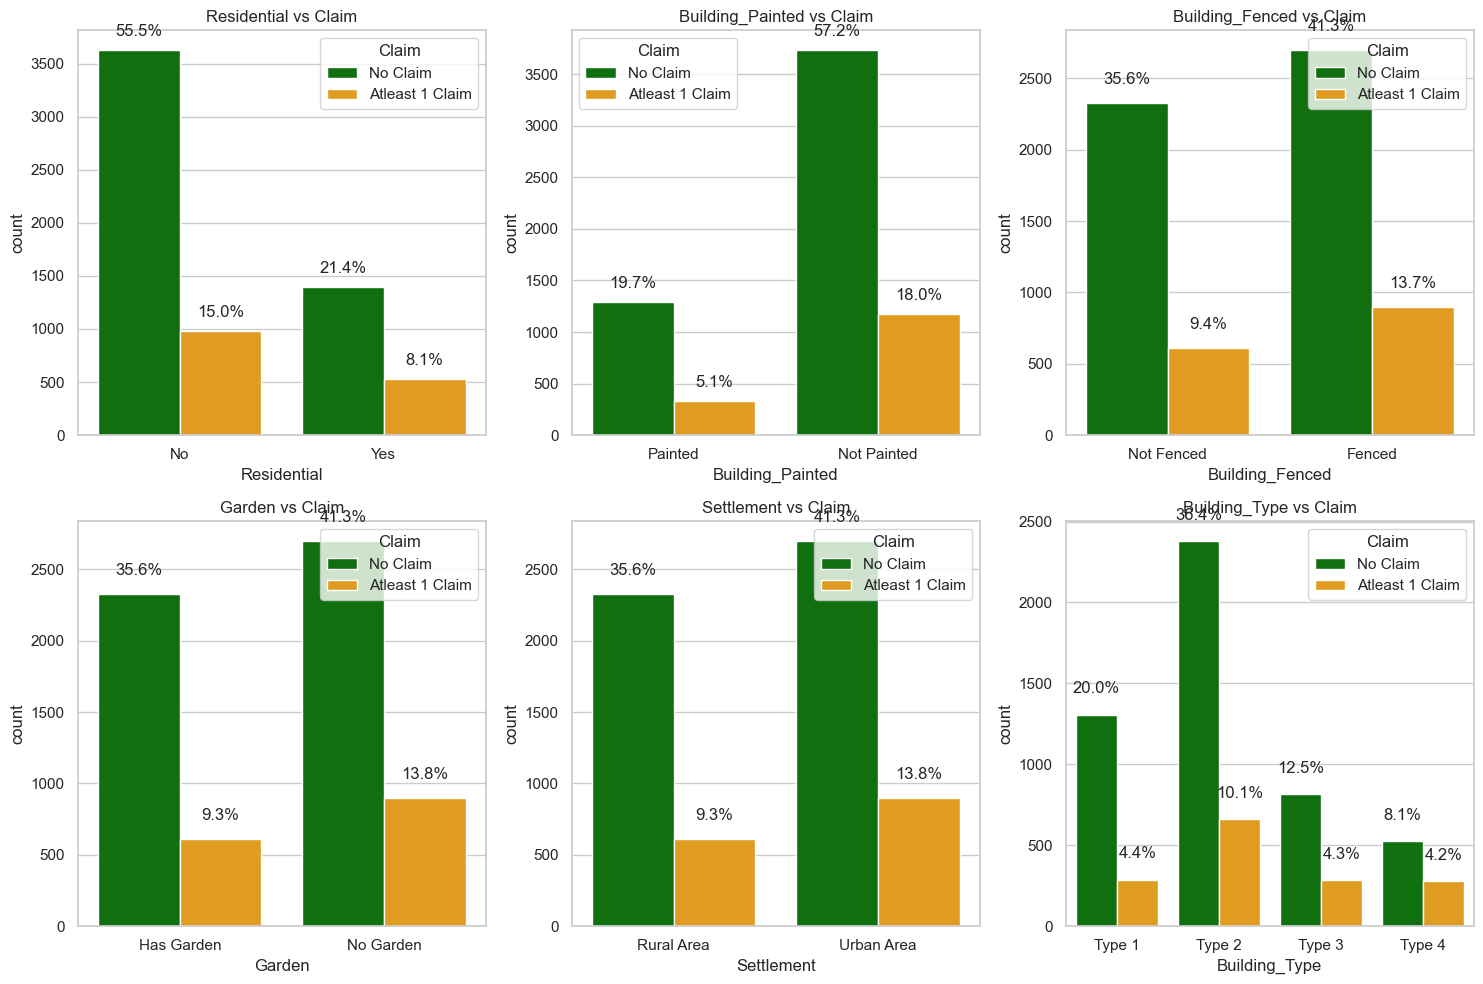

In [20]:
categorical_vars = ['Residential', 'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Building_Type']

num_rows = math.ceil(len(categorical_vars) / 3)

# Creating the  subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    ax = axes[i]
    sns.countplot(x=var, hue='Claim', palette=colors, data=dt_t, ax=ax)  
    ax.set_title(f'{var} vs Claim')

    total_height = len(dt_t)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_height)
        x_position = p.get_x() + p.get_width() / 2
        y_position = p.get_height() + 0.02 * total_height
        ax.text(x_position, y_position, percentage, ha='center')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [21]:
# Encoding categorical variables
dt_t = pd.get_dummies(data=dt_t, drop_first=False)
dt_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6543 entries, 0 to 7057
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Insured_Period                6543 non-null   float64
 1   Building Dimension            6543 non-null   float64
 2   YearsOfOccupancyBeforeClaim   6543 non-null   float64
 3   Residential_No                6543 non-null   uint8  
 4   Residential_Yes               6543 non-null   uint8  
 5   Building_Painted_Not Painted  6543 non-null   uint8  
 6   Building_Painted_Painted      6543 non-null   uint8  
 7   Building_Fenced_Fenced        6543 non-null   uint8  
 8   Building_Fenced_Not Fenced    6543 non-null   uint8  
 9   Garden_Has Garden             6543 non-null   uint8  
 10  Garden_No Garden              6543 non-null   uint8  
 11  Settlement_Rural Area         6543 non-null   uint8  
 12  Settlement_Urban Area         6543 non-null   uint8  
 13  Bui

In [22]:
dt_tr = dt_t.drop(columns = ['Residential_No','Building_Painted_Not Painted','Building_Fenced_Not Fenced','Garden_No Garden','Settlement_Rural Area','Claim_No Claim'])

In [23]:
dt_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6543 entries, 0 to 7057
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Insured_Period               6543 non-null   float64
 1   Building Dimension           6543 non-null   float64
 2   YearsOfOccupancyBeforeClaim  6543 non-null   float64
 3   Residential_Yes              6543 non-null   uint8  
 4   Building_Painted_Painted     6543 non-null   uint8  
 5   Building_Fenced_Fenced       6543 non-null   uint8  
 6   Garden_Has Garden            6543 non-null   uint8  
 7   Settlement_Urban Area        6543 non-null   uint8  
 8   Building_Type_Type 1         6543 non-null   uint8  
 9   Building_Type_Type 2         6543 non-null   uint8  
 10  Building_Type_Type 3         6543 non-null   uint8  
 11  Building_Type_Type 4         6543 non-null   uint8  
 12  Claim_Atleast 1 Claim        6543 non-null   uint8  
dtypes: float64(3), uin

Top 5 Features that will increase the likelihood of an insurance claim during a specific period
 Building Dimension       0.299
Building_Type_Type 4     0.102
Insured_Period           0.102
Residential_Yes          0.067
Settlement_Urban Area    0.050
dtype: float64

------------------------------------------------------

Top 5 Features that will decrease the likelihood of an insurance claim during a specific period
 YearsOfOccupancyBeforeClaim   -0.019
Building_Type_Type 2          -0.029
Building_Painted_Painted      -0.036
Garden_Has Garden             -0.050
Building_Type_Type 1          -0.069
dtype: float64


Text(0.5, 1.0, 'A bar plot showing the relationship of building characteristics and making at least an insurance claim during a specific period')

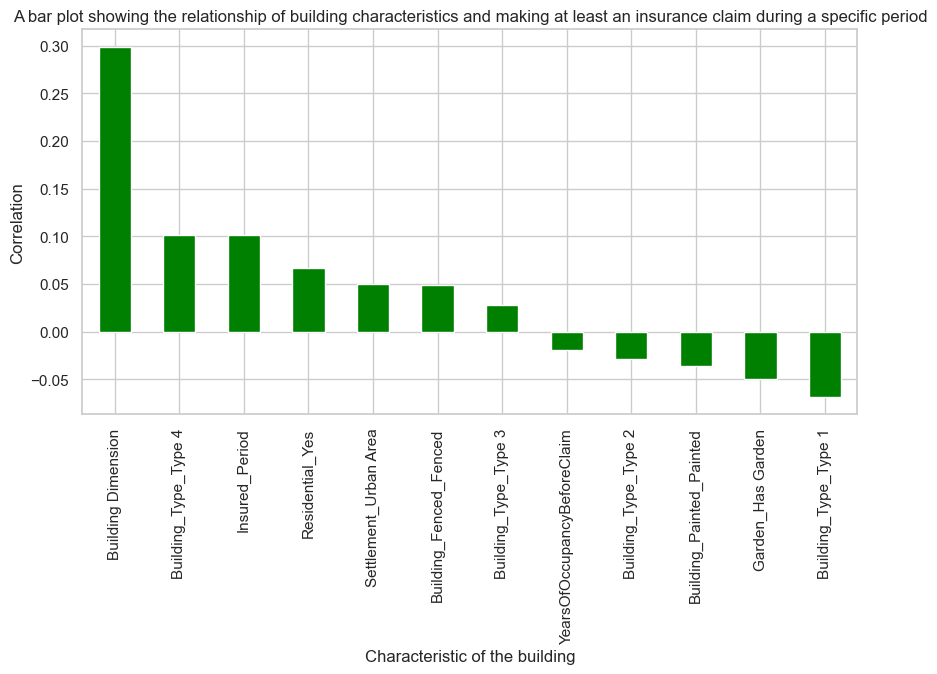

In [24]:
corr_with_attrition = dt_tr.drop(columns='Claim_Atleast 1 Claim').corrwith(dt_tr['Claim_Atleast 1 Claim']).sort_values(ascending=False)

print('Top 5 Features that will increase the likelihood of an insurance claim during a specific period\n',corr_with_attrition.round(3)[0:5])
print('\n------------------------------------------------------\n')
print('Top 5 Features that will decrease the likelihood of an insurance claim during a specific period\n',corr_with_attrition.round(3)[7:])

corr_with_attrition.plot.bar(figsize=(10,5), grid=True,color='green')
# plt.xticks(rotation=120)
plt.xlabel("Characteristic of the building")
plt.ylabel("Correlation")
plt.title("A bar plot showing the relationship of building characteristics and making at least an insurance claim during a specific period")

The correlation analysis reveals key factors influencing insurance claim likelihood in a given period. 
Generally there is a weak correlations implying lesser influence to insurance claim likelihood, 
- **However**, It is evident from the results that larger building dimensions, type 4 buildings, longer insured periods, residential properties, and settlements in urban areas are associated with a higher likelihood of insurance claims. 
- **Conversely**, a shorter occupancy period, buildings of type1 and type 2, painted buildings, and the absence of a garden are linked to a lower likelihood of insurance claims in a given period.

# Model Training and Evaluation

## Preparing the Data for Training
- This involved creating the target vector and feature Matrix
- 20 % of the Training set was used as Validation set (To be treated as the testing) and hence 80% as the training

In [25]:
# Separating the features (X) and target variable (y)
X = dt_tr.drop(columns='Claim_Atleast 1 Claim')
y = dt_tr['Claim_Atleast 1 Claim']

# Splitting the data into training and validation (testing set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training Base Models

In [26]:
# SVM (Support Vector Machine) Classifier
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

SVC(probability=True)

In [27]:
# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [28]:
# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [29]:
# K-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [30]:
# Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

## Base Model Evaluation
This Involved checking the accuarcy of the base MOdel before hyper paramenter tunning

In [31]:
# Settig Model Names
models = [svm_model,linear_model, logistic_model, knn_model, nb_model]
model_names = ['SVM', 'Linear Regression','Logistic Regression', 'KNN', 'Naive Bayes']

In [32]:
results = []

for model, name in zip(models, model_names):
    predictions = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, predictions)
    classification_rep = classification_report(y_test, predictions, output_dict=True)
    auc_score = roc_auc_score(y_test, predictions)
    
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': classification_rep['1']['precision'],
        'Recall': classification_rep['1']['recall'],
        'F1 Score': classification_rep['1']['f1-score'],
        'AUC': auc_score,
        'FPR': fpr,
        'TPR': tpr
    })

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by='AUC', ascending=False)

results_df.drop(columns = ['FPR','TPR'])


,Model,Accuracy,Precision,Recall,F1 Score,AUC
4,Naive Bayes,0.754775,0.487395,0.368254,0.419530,0.622759
3,KNN,0.758594,0.496815,0.247619,0.330508,0.584071
2,Logistic Regression,0.783040,0.718310,0.161905,0.264249,0.570892
1,Linear Regression,0.777693,0.714286,0.126984,0.215633,0.555444
0,SVM,0.770053,0.733333,0.069841,0.127536,0.530896


The Results Above show a comparison among different initial models.
With An to predict whether a building will claim at least one insurance and Uisng AUC as the primary metric, the evaluation reveals Naive bayes demonstrates the best score of 0.622759, which suggests it is 62.3% effective in identifying a building where at least one insurance claim is likely in a given period.

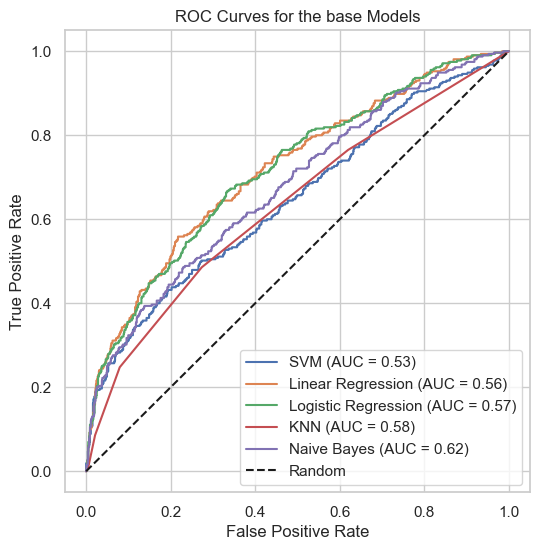

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(6, 6))

for name, model in zip(model_names, models):
    # Use predict_proba instead of predict
    if hasattr(model, "predict_proba"):
        predictions = model.predict_proba(X_test)[:, 1]  # Use the probability of the positive class
    else:
        predictions = model.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results_df.loc[results_df["Model"] == name, "AUC"].values[0]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for the base Models')
plt.legend()
plt.show()


## Hyperparamenter Tunning
Grid Search will be use to get the best parameters from a grib of possible parameter using 3 fold cross validation

NOTE: A tradeoff was made between the quality and runtime due to lower computing power, however an optimal balance was obtain;this was mplemented by reducing the Search Space, Reduced Cross-Validation Folds to 5. This Combination reduced the rutimeto about an average of 5 minutes.

In [34]:
# SVM
svm_param_grid = {
    'C': [0.1, 2]
}
svm_grid = GridSearchCV(estimator=SVC(), param_grid=svm_param_grid, cv= 5)
svm_grid.fit(X_train, y_train)
svm_model1 = svm_grid.best_estimator_

In [35]:
# Linear Regression
linear_param_grid = {
    'fit_intercept': [True, False]
}

linear_grid = GridSearchCV(estimator=LinearRegression(), param_grid=linear_param_grid, cv=5)
linear_grid.fit(X_train, y_train)
linear_model1 = linear_grid.best_estimator_


In [36]:
# Logistic Regression
logistic_param_grid = {
    'C': [0.1, 1], 
    'penalty': ['l1', 'l2']
}

logistic_grid = GridSearchCV(estimator=LogisticRegression(), param_grid=logistic_param_grid, cv=5)
logistic_grid.fit(X_train, y_train)
logistic_model1 = logistic_grid.best_estimator_


In [37]:
# K-Nearest Neighbors Classifier
knn_param_grid = {
    'n_neighbors': [3, 5, 7], 
    'weights': ['uniform', 'distance']
}

knn_grid = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=knn_param_grid, cv=5)
knn_grid.fit(X_train, y_train)
knn_model1 = knn_grid.best_estimator_


In [38]:
# Settig Trained Model Names
models1 = [svm_model1,linear_model1, logistic_model1, knn_model1, nb_model]
model_names1 = ['SVM', 'Linear Regression','Logistic Regression', 'KNN', 'Naive Bayes']

## Tunned Model Evaluation

In [39]:
## a blank data frame for results
results1 = []

for model, name in zip(models1, model_names1):
    predictions = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, predictions)
    classification_rep = classification_report(y_test, predictions, output_dict=True)
    auc_score  = roc_auc_score(y_test, predictions)
    
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    results1.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': classification_rep['1']['precision'],
        'Recall': classification_rep['1']['recall'],
        'F1 Score': classification_rep['1']['f1-score'],
        'AUC': auc_score,
        'FPR': fpr,
        'TPR': tpr
    })
results_df1 = pd.DataFrame(results1)
    
results_df1 = results_df1.sort_values(by='AUC', ascending=False)

results_df1.drop(columns = ['FPR','TPR'])


,Model,Accuracy,Precision,Recall,F1 Score,AUC
4,Naive Bayes,0.754775,0.487395,0.368254,0.419530,0.622759
3,KNN,0.760886,0.507812,0.206349,0.293454,0.571484
2,Logistic Regression,0.783040,0.718310,0.161905,0.264249,0.570892
1,Linear Regression,0.777693,0.714286,0.126984,0.215633,0.555444
0,SVM,0.770817,0.727273,0.076190,0.137931,0.533568


- Interestingly, After Parameter tunning,the results in the table above show that there was no significant change to area under the curve of the mode implying that the current parameter tuning didnot improve nor distort the models' ability to discriminate between buildings that claim at insurance atleast one in a given period.

- Therfore, the evaluation shows Naive bayes as the best model (AUC = 0.622759), which suggests it is 62.3% effective in identifying a building where at least one insurance claim is likely in a given period.
- Additonally,If considering a balance between precision, recall, and F1 score, the Logistic Regression model appears to be the best perfroming Compared to the other models, It effectively balances overall predictive performance, capturing a considerable proportion of actual insurance claims (recall = 16.19%) while maintaining a reasonable level of precision (precision = 71.83%) in identifying true positive cases, making it a best model for predicting a potential insurance claim.

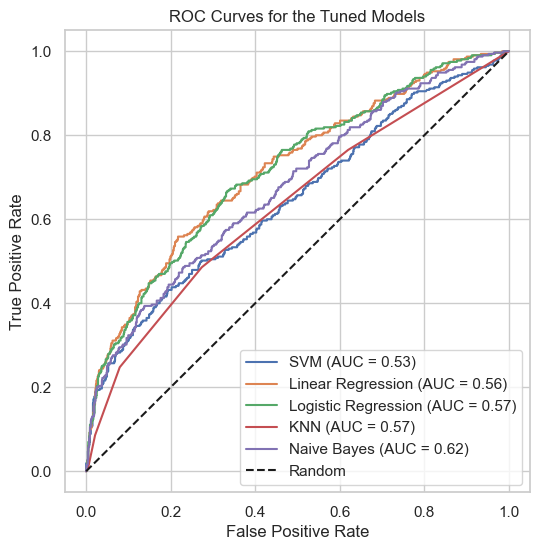

In [40]:
plt.figure(figsize=(6, 6))

for name, model in zip(model_names, models):
    if hasattr(model, "predict_proba"):
        predictions = model.predict_proba(X_test)[:, 1]
    else:
        predictions = model.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results_df1.loc[results_df1["Model"] == name, "AUC"].values[0]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for the Tuned Models')
plt.legend()
plt.show()

# Submission Preparation
Made predictions on the test dataset using the best-performing model

In [45]:
# Preparing the data for the Actual test case
dt_ts = dt[dt['Dataset'] == 'Test']
dt_ts = dt_ts.drop(columns = ["Claim", "Dataset"])
dt_ts = pd.get_dummies(data=dt_ts, drop_first=False)
dt_ts = dt_ts.drop(columns = ['Residential_No','Building_Painted_Not Painted','Building_Fenced_Not Fenced','Garden_No Garden','Settlement_Rural Area'])
X_submission = dt_ts

In [42]:
dt_ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3069 entries, 7160 to 10228
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Insured_Period               3069 non-null   float64
 1   Building Dimension           3056 non-null   float64
 2   YearsOfOccupancyBeforeClaim  2341 non-null   float64
 3   Residential_Yes              3069 non-null   uint8  
 4   Building_Painted_Painted     3069 non-null   uint8  
 5   Building_Fenced_Fenced       3069 non-null   uint8  
 6   Garden_Has Garden            3069 non-null   uint8  
 7   Settlement_Urban Area        3069 non-null   uint8  
 8   Building_Type_Type 1         3069 non-null   uint8  
 9   Building_Type_Type 2         3069 non-null   uint8  
 10  Building_Type_Type 3         3069 non-null   uint8  
 11  Building_Type_Type 4         3069 non-null   uint8  
dtypes: float64(3), uint8(9)
memory usage: 122.9 KB


In [46]:
X_submission = X_submission.fillna(X_submission.mean())
X_submission.isnull().sum()

Insured_Period                 0
Building Dimension             0
YearsOfOccupancyBeforeClaim    0
Residential_Yes                0
Building_Painted_Painted       0
Building_Fenced_Fenced         0
Garden_Has Garden              0
Settlement_Urban Area          0
Building_Type_Type 1           0
Building_Type_Type 2           0
Building_Type_Type 3           0
Building_Type_Type 4           0
dtype: int64

In [ ]:
### Submission Prediction for the Logistic Model
submission_predictions = logistic_model.predict(X_submission)
submission = pd.DataFrame({'Customer Id': dt_test['Customer Id'], 'Claim': submission_predictions})
submission.to_csv('Submission Predictions/Logistic_Regression_Submission.csv', index=False)

In [ ]:
### Submission Prediction for the SVM Model
submission_predictions = svm_model.predict(X_submission)
submission = pd.DataFrame({'Customer Id': dt_test['Customer Id'], 'Claim': submission_predictions})
submission.to_csv('Submission Predictions/SVM_Submission.csv', index=False)

In [ ]:
### Submission Prediction for the Liner REgression Model
submission_predictions = linear_model.predict(X_submission)
submission = pd.DataFrame({'Customer Id': dt_test['Customer Id'], 'Claim': submission_predictions})
submission.to_csv('Submission Predictions/Linear_Regression_Submission.csv', index=False)

In [ ]:
### Submission Prediction for the KNN Model
submission_predictions = knn_model.predict(X_submission)
submission = pd.DataFrame({'Customer Id': dt_test['Customer Id'], 'Claim': submission_predictions})
submission.to_csv('Submission Predictions/KNN_Submission.csv', index=False)

In [ ]:
### Submission Prediction for the Naive Bayes Model
submission_predictions = nb_model.predict(X_submission)
submission = pd.DataFrame({'Customer Id': dt_test['Customer Id'], 'Claim': submission_predictions})
submission.to_csv('Submission Predictions/Naive_Bayes_Submission.csv', index=False)